#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [108]:
df_stock1 = pd.read_csv("../static/data/ncm.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
6004,25/07/2022,18.950001,19.299999,18.879999,19.280001,19.280001,5904903.0,1.35,1.75,125.0
6005,26/07/2022,18.719999,19.000000,18.600000,18.680000,18.680000,5786445.0,1.35,1.75,125.0
6006,27/07/2022,18.879999,19.080000,18.420000,18.510000,18.510000,25147040.0,1.35,2.50,125.0
6007,28/07/2022,18.719999,18.754999,18.490000,18.610001,18.610001,15484935.0,1.35,2.50,125.0
6008,29/07/2022,18.889999,19.299999,18.780001,19.299999,19.299999,14552543.0,1.35,2.50,125.0


In [109]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.ncm.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.ncm.insert_many(records)

In [110]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.ncm.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.ncm.delete_one(
    {'Date': last_date}
)

DELETE: 29/07/2022 19.299999


In [111]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.ncm.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 28/07/2022 18.610001
Previous last date in MongoDb: 28-07-2022. Today's date: 02-08-2022


In [112]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'NCM.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-28,18.754999,18.490000,18.719999,18.610001,15484935,18.610001
2022-07-29,19.299999,18.780001,18.889999,19.299999,14552543,19.299999
2022-08-01,19.580000,19.059999,19.500000,19.270000,4266708,19.270000
2022-08-02,19.620001,19.120001,19.270000,19.520000,5480300,19.520000


In [113]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-29,19.299999,18.780001,18.889999,19.299999,14552543,19.299999
2022-08-01,19.580000,19.059999,19.500000,19.270000,4266708,19.270000
2022-08-02,19.620001,19.120001,19.270000,19.520000,5480300,19.520000


In [114]:
tot=len(stock_quote)
rba=1.35
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
# print(a,b,c)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)
stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_4904/1960956411.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_4904/1960956411.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_4904/1960956411.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/07/2022,19.299999,18.780001,18.889999,19.299999,14552543,19.299999,1.35,2.5,125
1,01/08/2022,19.580000,19.059999,19.500000,19.270000,4266708,19.270000,1.35,2.5,125
2,02/08/2022,19.620001,19.120001,19.270000,19.520000,5480300,19.520000,1.35,2.5,125


UPDATE MONGO DB

In [115]:
records=stock_quote.to_dict('records')
records

[{'Date': '29/07/2022',
  'High': 19.299999237060547,
  'Low': 18.780000686645508,
  'Open': 18.889999389648438,
  'Close': 19.299999237060547,
  'Volume': 14552543,
  'Adj Close': 19.299999237060547,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '01/08/2022',
  'High': 19.579999923706055,
  'Low': 19.059999465942383,
  'Open': 19.5,
  'Close': 19.270000457763672,
  'Volume': 4266708,
  'Adj Close': 19.270000457763672,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '02/08/2022',
  'High': 19.6200008392334,
  'Low': 19.1200008392334,
  'Open': 19.270000457763672,
  'Close': 19.520000457763672,
  'Volume': 5480300,
  'Adj Close': 19.520000457763672,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125}]

In [116]:
#INSERT NEW DATA INTO MONGODB
db.ncm.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.ncm.find()))

last_val = df_mongo.iloc[-10:].values
print(last_val)

[[ObjectId('62e8ee0e664b65ec69d765c4') '20/07/2022' 18.860001 19.049999
  18.75 19.040001 19.040001 3974625.0 1.35 1.75 125.0]
 [ObjectId('62e8ee0e664b65ec69d765c5') '21/07/2022' 19.309999 19.469999
  19.040001 19.35 19.35 15695242.0 1.35 1.75 125.0]
 [ObjectId('62e8ee0e664b65ec69d765c6') '22/07/2022' 19.34 19.799999
  19.165001 19.26 19.26 7109965.0 1.35 1.75 125.0]
 [ObjectId('62e8ee0e664b65ec69d765c7') '25/07/2022' 18.950001 19.299999
  18.879999 19.280001 19.280001 5904903.0 1.35 1.75 125.0]
 [ObjectId('62e8ee0e664b65ec69d765c8') '26/07/2022' 18.719999 19.0 18.6
  18.68 18.68 5786445.0 1.35 1.75 125.0]
 [ObjectId('62e8ee0e664b65ec69d765c9') '27/07/2022' 18.879999 19.08 18.42
  18.51 18.51 25147040.0 1.35 2.5 125.0]
 [ObjectId('62e8ee0e664b65ec69d765ca') '28/07/2022' 18.719999 18.754999
  18.49 18.610001 18.610001 15484935.0 1.35 2.5 125.0]
 [ObjectId('62e8ee11664b65ec69d765cc') '29/07/2022' 18.889999389648438
  19.299999237060547 18.780000686645508 19.299999237060547
  19.299999237

In [117]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

02/08/2022 19.520000457763672


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [118]:
df_mongo = pd.DataFrame(list(db.ncm.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(5977, 1)

In [119]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [120]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4782, 1)

In [121]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.00143409, 0.00040975, 0.00090144, 0.00081949, 0.00204871,
       0.00368767, 0.00430229, 0.00389255, 0.00434327, 0.00491689,
       0.0028682 , 0.00204871, 0.00327793, 0.0028682 , 0.00307305,
       0.00307305, 0.00307305, 0.00368767, 0.00409742, 0.00553151,
       0.00327793, 0.00442522, 0.00491689, 0.0034828 , 0.00245846,
       0.0028682 , 0.00389255, 0.00327793, 0.00389255, 0.00389255,
       0.0034828 , 0.00182335, 0.00040975, 0.00081949, 0.        ,
       0.00061462, 0.00225358, 0.00307305, 0.0034828 , 0.00307305,
       0.00327793, 0.00389255, 0.00409742, 0.00471204, 0.00780558,
       0.00798997, 0.00819484, 0.00901431, 0.01085815, 0.01208739,
       0.00983381, 0.00942406, 0.00983381, 0.00962893, 0.00942406,
       0.01106302, 0.01003868, 0.01079669, 0.01454582, 0.0147507 ])]
[0.015160443032826147]


# Prepare train data for LSTM model

In [122]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4722, 60)

In [123]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4722, 60, 1)

# Build the LSTM model

In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [125]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [126]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4722/4722 [==============================] - 86s 18ms/step - loss: 0.0013


In [127]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [128]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [129]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [130]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.6503748378672325

C:\Users\antoi\AppData\Local\Temp/ipykernel_4904/465677522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


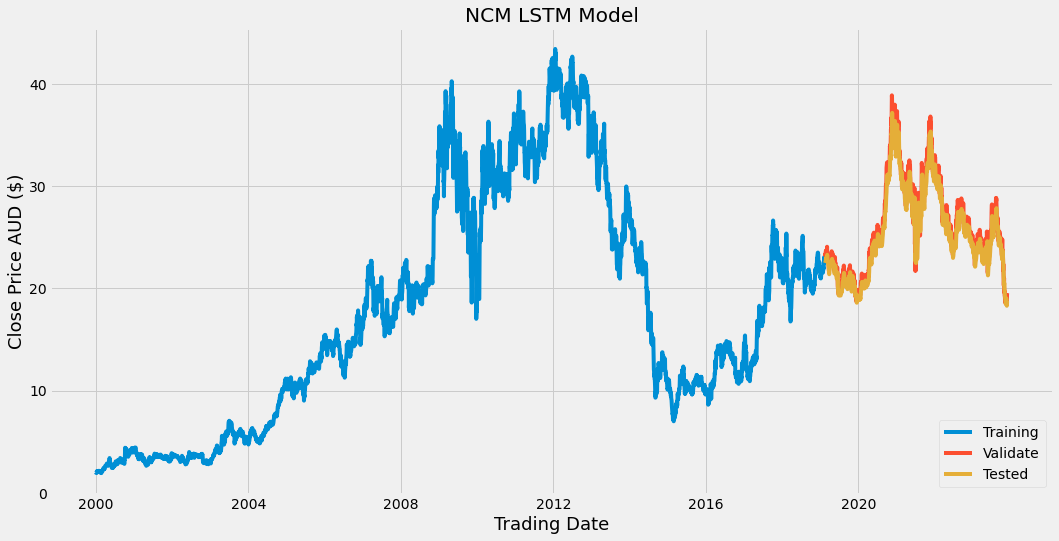

In [131]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('NCM LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/ncm_graph.png')
plt.show()

# Test data Predictions on the Model

In [132]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_4904/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
4782  23.190001    22.478855    0.711146
4783  23.340000    22.530840    0.809160
4784  23.219999    22.612167    0.607832
4785  23.400000    22.611385    0.788615
4786  23.610001    22.672220    0.937781
...         ...          ...         ...
5972  18.510000    18.762705   -0.252705
5973  18.610001    18.453112    0.156889
5974  19.299999    18.288637    1.011362
5975  19.270000    18.504202    0.765799
5976  19.520000    18.720276    0.799725

[1195 rows x 3 columns]>

In [133]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.ncm.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [134]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [135]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

02/08/2022 Last close $19.520000457763672 Predicted next day share price $18


# Save the Model

In [136]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/ncm_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list ncm_sixty and load df

#PREDICT USING LOADED MODEL

In [137]:
from keras.models import load_model
model_in = load_model('../static/ncm_model.sav')

In [138]:
# query the ncm collection and load into dataframe

df_mongo = pd.DataFrame(list(db.ncm.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[24.67      ],
       [24.41      ],
       [24.549999  ],
       [24.280001  ],
       [24.459999  ],
       [24.719999  ],
       [24.799999  ],
       [24.459999  ],
       [25.32      ],
       [25.27      ],
       [25.02      ],
       [25.209999  ],
       [24.6       ],
       [24.690001  ],
       [24.59      ],
       [24.700001  ],
       [24.15      ],
       [24.049999  ],
       [24.540001  ],
       [24.290001  ],
       [23.98      ],
       [24.120001  ],
       [23.76      ],
       [23.17      ],
       [22.34      ],
       [22.76      ],
       [23.6       ],
       [23.77      ],
       [23.65      ],
       [23.51      ],
       [23.549999  ],
       [23.01      ],
       [22.700001  ],
       [21.66      ],
       [22.01      ],
       [21.459999  ],
       [20.889999  ],
       [20.23      ],
       [20.549999  ],
       [20.73      ],
       [19.58      ],
       [19.41      ],
       [19.75      ],
       [19.059999  ],
       [19.08      ],
       [18

#Create a function to loop through the days input

In [139]:
from keras.models import load_model
model_in = load_model('../static/ncm_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_ncm(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_ncm(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[18.95,
 19.0,
 19.02,
 19.03,
 19.03,
 19.02,
 19.01,
 19.0,
 19.0,
 18.99,
 18.98,
 18.97,
 18.97,
 18.97,
 18.96,
 18.96,
 18.96,
 18.96,
 18.96,
 18.95,
 18.95,
 18.95,
 18.95,
 18.95,
 18.94,
 18.94,
 18.94,
 18.94,
 18.94,
 18.93,
 18.93,
 18.93,
 18.93,
 18.92,
 18.92,
 18.92,
 18.91,
 18.91,
 18.9,
 18.9,
 18.89,
 18.89,
 18.89,
 18.88,
 18.87,
 18.87,
 18.86,
 18.86,
 18.85,
 18.85,
 18.84,
 18.84,
 18.84,
 18.83,
 18.83,
 18.82,
 18.82,
 18.83,
 18.83,
 18.83,
 18.83,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.84,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.83,
 18.8

In [140]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  03-08-2022  Wednesday
1        2  04-08-2022   Thursday
2        3  05-08-2022     Friday
3        4  08-08-2022     Monday
4        5  09-08-2022    Tuesday
..     ...         ...        ...
203    204  15-05-2023     Monday
204    205  16-05-2023    Tuesday
205    206  17-05-2023  Wednesday
206    207  18-05-2023   Thursday
207    208  19-05-2023     Friday

[208 rows x 3 columns]>


In [141]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')


#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')

today_str=today1.strftime('%d-%m-%Y')

print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()

    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[-10:].values
    print(dates_val)


2022-07-28 00:00:00 2022-08-02 00:00:00
-6 days, 4:30:37.849173
[[ObjectId('62e112b2fb7cbba54bf62c9f') 199 '02-05-2023' 'Tuesday']
 [ObjectId('62e112b2fb7cbba54bf62ca0') 200 '03-05-2023' 'Wednesday']
 [ObjectId('62e112b2fb7cbba54bf62ca1') 201 '04-05-2023' 'Thursday']
 [ObjectId('62e112b2fb7cbba54bf62ca2') 202 '05-05-2023' 'Friday']
 [ObjectId('62e112b2fb7cbba54bf62ca3') 203 '08-05-2023' 'Monday']
 [ObjectId('62e112b2fb7cbba54bf62ca4') 204 '09-05-2023' 'Tuesday']
 [ObjectId('62e112b2fb7cbba54bf62ca5') 205 '10-05-2023' 'Wednesday']
 [ObjectId('62e112b2fb7cbba54bf62ca6') 206 '11-05-2023' 'Thursday']
 [ObjectId('62e112b2fb7cbba54bf62ca7') 207 '12-05-2023' 'Friday']
 [ObjectId('62e112b2fb7cbba54bf62ca8') 208 '15-05-2023' 'Monday']]


In [142]:
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0:,1:]
# dates_df['Count'].dtype
# dates_df_iloc = dates_df.iloc[0:180,1:]
dates_val

,Count,Date,DOW
0,1,28-07-2022,Thursday
1,2,29-07-2022,Friday
2,3,01-08-2022,Monday
3,4,02-08-2022,Tuesday
4,5,03-08-2022,Wednesday
...,...,...,...
203,204,09-05-2023,Tuesday
204,205,10-05-2023,Wednesday
205,206,11-05-2023,Thursday
206,207,12-05-2023,Friday


In [143]:
# import pandas as pd
# dates_df = pd.read_csv("../static/data/dates.csv")
# dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
# dates_df

C:\Users\antoi\AppData\Local\Temp/ipykernel_4904/2212879804.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


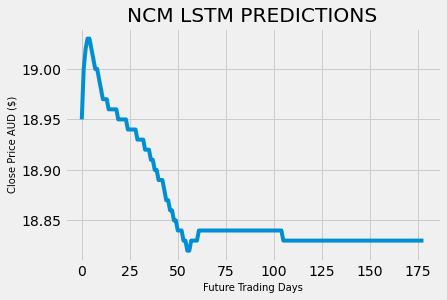

In [144]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('NCM LSTM PREDICTIONS')
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.savefig('../static/data/images/pred/ncm_pred.png', bbox_inches="tight")
plt.show()

In [145]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
print(my_dict[0])
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
# print(price_dict[0])

{'_id': ObjectId('62e112b2fb7cbba54bf62bd9'), 'Count': 1, 'Date': '28-07-2022', 'DOW': 'Thursday', 'Price': 18.95}


In [146]:
len_df_mongo = len(df_mongo) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs

new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)
print(train_data_len,len_df_mongo,len_pred_df)


4782 5977 6155


C:\Users\antoi\AppData\Local\Temp/ipykernel_4904/3970846848.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


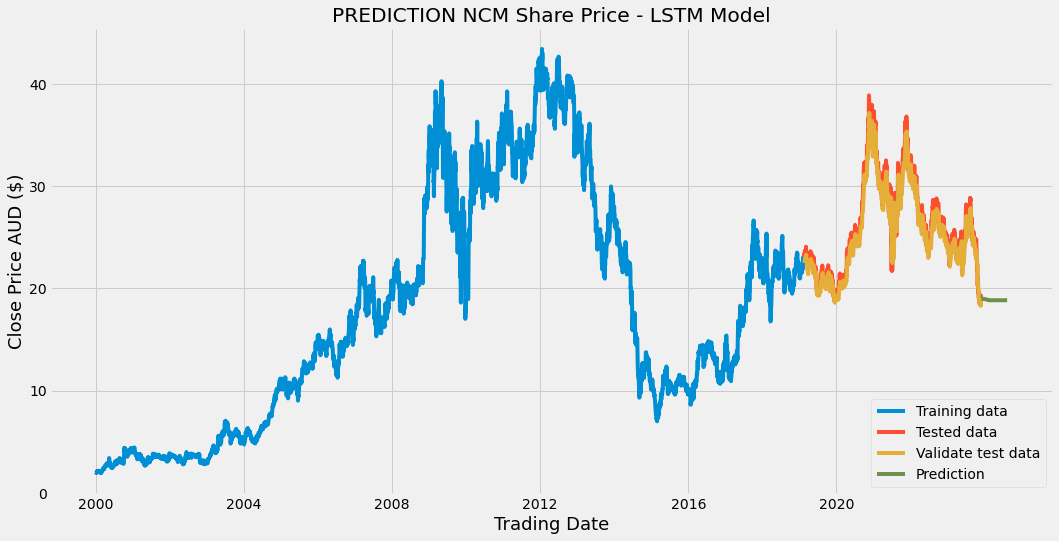

In [147]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION NCM Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/ncm_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [148]:
# Query all
name = 'NCM'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e5f95b66dc62408069f355'), 'model': 'RFR', 'name': 'NCM', 'date': '29/07/2022', 'predicted': 32, 'actual': 19, 'difference': 13.4814, 'accuracy': 95.05}
{'_id': ObjectId('62e8ed06664b65ec69d71fbd'), 'model': 'LSTM', 'name': 'NCM', 'date': '28/07/2022', 'predicted': 17, 'actual': 18.61, 'difference': -1.61, 'rmse': 1.56957}


In [149]:
# Delete a document from a collection
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e5f95b66dc62408069f355'), 'model': 'RFR', 'name': 'NCM', 'date': '29/07/2022', 'predicted': 32, 'actual': 19, 'difference': 13.4814, 'accuracy': 95.05}


In [150]:
# Set keys and values of company
name = 'NCM'
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 02/08/2022,predicted $18, actual $19.52, difference -1.5199999999999996, rmse 0.65037


In [151]:
# Insert a document into the 'companys' collection
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62e5f95b66dc62408069f355'), 'model': 'RFR', 'name': 'NCM', 'date': '29/07/2022', 'predicted': 32, 'actual': 19, 'difference': 13.4814, 'accuracy': 95.05}
{'_id': ObjectId('62e8ee73664b65ec69d765cf'), 'model': 'LSTM', 'name': 'NCM', 'date': '02/08/2022', 'predicted': 18, 'actual': 19.52, 'difference': -1.52, 'rmse': 0.65037}


In [152]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62df8ae0427af058c4334ede'), 'model': 'RFR', 'name': 'CBA', 'date': '26/07/2022', 'predicted': 97, 'actual': 96, 'differece': 1.0204273335669143, 'accuracy': 97.43}
{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}
{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}
{'_id': ObjectId('62e22127c7e5ff501a0a119c'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/07/2022', 'predicted': 20.96, 'actual': 21.47, 'differece': -0.509999999999998, 'rmse': 0.17596}
{'_id': ObjectId('62e223a5553c4e8d8e53f30a'), 'model': 'LSTM', 'name': 'NHC', 'date': 

In [153]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62df8ae0427af058c4334ede'), 'model': 'RFR', 'name': 'CBA', 'date': '26/07/2022', 'predicted': 97, 'actual': 96, 'differece': 1.0204273335669143, 'accuracy': 97.43}
{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}
{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}
{'_id': ObjectId('62e22127c7e5ff501a0a119c'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/07/2022', 'predicted': 20.96, 'actual': 21.47, 'differece': -0.509999999999998, 'rmse': 0.17596}
{'_id': ObjectId('62e223a5553c4e8d8e53f30a'), 'model': 'LSTM', 'name': 'NHC', 'date': 